# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
RANDOM = 42


# 1. Загрузка и подготовка данных

Загрузим данные

In [2]:
zero_frame = pd.read_csv("geo_data_0.csv")
first_frame = pd.read_csv("geo_data_1.csv")
second_frame = pd.read_csv("geo_data_2.csv")

In [3]:
print("####################")
print("#    Zero Frame    #")
print("####################")
print()
display(zero_frame.head())
print()
print("####################")
print("#    First Frame   #")
print("####################")
print()
display(first_frame.head())
print()
print("####################")
print("#    Second Frame  #")
print("####################")
print()
display(second_frame.head())

####################
#    Zero Frame    #
####################



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



####################
#    First Frame   #
####################



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



####################
#    Second Frame  #
####################



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Проведем первичное изучение данных


In [4]:
print("####################")
print("#    Zero Frame    #")
print("####################")
print()
print(zero_frame.info())
print()
print("####################")
print("#    First Frame   #")
print("####################")
print()
print(first_frame.info())
print()
print("####################")
print("#    Second Frame  #")
print("####################")
print()
print(second_frame.info())

####################
#    Zero Frame    #
####################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

####################
#    First Frame   #
####################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ M

In [11]:
print("####################")
print("#    Zero Frame    #")
print("####################")
print()
print("Количество дубликатов:",zero_frame.duplicated().sum())
print()
print("####################")
print("#    First Frame   #")
print("####################")
print()
print("Количество дубликатов:",first_frame.duplicated().sum())
print()
print("####################")
print("#    Second Frame  #")
print("####################")
print()
print("Количество дубликатов:",second_frame.duplicated().sum())

####################
#    Zero Frame    #
####################

Количество дубликатов: 0

####################
#    First Frame   #
####################

Количество дубликатов: 0

####################
#    Second Frame  #
####################

Количество дубликатов: 0


In [6]:
print("####################")
print("#    Zero Frame    #")
print("####################")
print()
display(zero_frame.describe())
print()
print("####################")
print("#    First Frame   #")
print("####################")
print()
display(first_frame.describe())
print()
print("####################")
print("#    Second Frame  #")
print("####################")
print()
display(second_frame.describe())

####################
#    Zero Frame    #
####################



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



####################
#    First Frame   #
####################



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



####################
#    Second Frame  #
####################



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


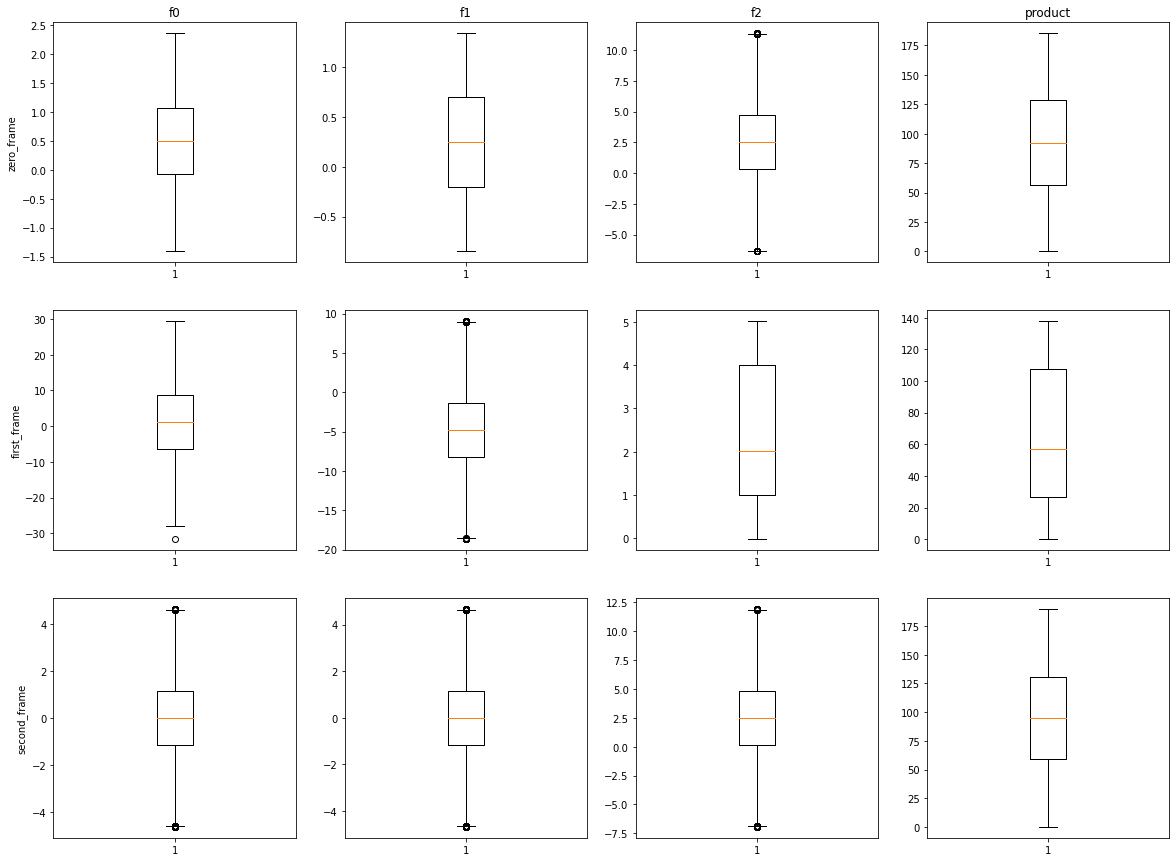

In [10]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["zero_frame","first_frame","second_frame"]
num_columns = zero_frame.columns[1:]
num_columns_with_columns = zip(zero_frame.columns[1:],range(4))
all_frames_with_rows = zip([zero_frame,first_frame,second_frame],range(3))
# Построим графики
for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
# Добавим название фрейма изображаемого на графике
for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])
# Добавим название столбца изображаемого на графике
for column in range(4):
    ax[0][column].set_title(num_columns[column])

Заметим, что в некоторых стобцах есть данные выходящие за границы. Эти данные будут мешать моделе обучаться отвлекая еею Поэтому их необходимо удалить.
Выпишем необходимые столбцы для обработки в формате (фрейм, столбец):
1. (zero_frame,"f2")
1. (first_frame,"f1")
1. (second_frame,"f0")
1. (second_frame,"f1")
1. (second_frame,"f2")

Исправим данные

In [8]:
def remove_ouliers(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    
    q75=np.array(frame[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index

In [9]:
noise_data = [(zero_frame,"f2"),
 (first_frame,"f1"),
 (second_frame,"f0"),
 (second_frame,"f1"),
 (second_frame,"f2")]

for frame,column in noise_data:
    indexes = remove_ouliers(frame,column)
    frame.drop(indexes,axis = 0,inplace = True)

Количество строк, выбранных для удаления:  506
Количество строк, выбранных для удаления:  636
Количество строк, выбранных для удаления:  733
Количество строк, выбранных для удаления:  682
Количество строк, выбранных для удаления:  582


Выборки пострадали не сильно, в первых двух потери составили менее 1%, в последней же потеря данных составила 2%

Проверим корреляцию между признаками

In [13]:
print("####################")
print("#    Zero Frame    #")
print("####################")
print()
display(zero_frame.corr())
print()
print("####################")
print("#    First Frame   #")
print("####################")
print()
display(first_frame.corr())
print()
print("####################")
print("#    Second Frame  #")
print("####################")
print()
display(second_frame.corr())

####################
#    Zero Frame    #
####################



,f0,f1,f2,product
f0,1.000000,-0.440716,-0.003339,0.143591
f1,-0.440716,1.000000,0.001098,-0.192748
f2,-0.003339,0.001098,1.000000,0.480159
product,0.143591,-0.192748,0.480159,1.000000



####################
#    First Frame   #
####################



,f0,f1,f2,product
f0,1.000000,0.178877,-0.001670,-0.030389
f1,0.178877,1.000000,-0.002756,-0.010174
f2,-0.001670,-0.002756,1.000000,0.999397
product,-0.030389,-0.010174,0.999397,1.000000



####################
#    Second Frame  #
####################



,f0,f1,f2,product
f0,1.000000,0.000649,0.000473,-0.002962
f1,0.000649,1.000000,0.000710,-0.000895
f2,0.000473,0.000710,1.000000,0.441211
product,-0.002962,-0.000895,0.441211,1.000000


Заметим, что в нулевом фрейме признаки f0 и f1 отрицательно коррелируют относительно друг друга и f2 слабо положительно коррелирует с целевым признаком. Так же в первом фрейме очень сильно коррелирует целевой признак и f2. Во втором фрейме так же есть коррелирующие признаки, такие как f2 и product.

Если в случе с первым фреймом все достаточно понятно, там очень высокая корреляция и признак f2 следует удалить, то вот в случае с другими двумя выборками стоит опираться на результатб который мы получим на моделях, Следовательно необходимо подготовить 7 выборок:
1. Нулевая со всеми столбцами
1. Нулевая без f1
1. Нулевая без f2
1. Нулевая без f1 и f2
1. Первая без f2
1. Вторая без f2
1. Вторая со всеми столбцами

In [14]:
zero_frame_out_f1 = zero_frame.drop(["f1"],axis = 1)
zero_frame_out_f2 = zero_frame.drop(["f2"],axis = 1)
zero_frame_out_f12 = zero_frame.drop(["f1","f2"],axis = 1)
first_frame_out_f2 = first_frame.drop(["f2"],axis = 1)
second_frame_out_f2 = second_frame.drop(["f2"],axis = 1)

Результаты первичного анализа:
1. Пропуски - отсутсвуют
2. Типы столбцов - корректны
3. Названия столбцов - корректны 
1. Дубликаты - отсутсвуют
1. Объем запасов - положительный 
1. Выбросы - удалены
1. Коррелирующие признаки - учтены

# 2. Обучение и проверка модели

# 3. Подготовка к расчёту прибыли

# 4. Расчёт прибыли и рисков 

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован